In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima

In [28]:
cab_data=pd.read_csv("Cab_Data.csv")
city_data=pd.read_csv("City.csv")
customer_data=pd.read_csv("Customer_ID.csv")
transc_data=pd.read_csv("Transaction_ID.csv")
holiday_data = pd.read_csv("us_holidays.csv")

In [29]:
holiday_data

,date,holiday_name,holiday,year,month,wday,weekend,long_holiday,school_break,dayno
0,2012-01-01,New Year Day,True,2012,1,7,True,True,christmas_break,1
1,2012-01-02,FALSE,False,2012,1,1,False,False,no_break,2
2,2012-01-03,FALSE,False,2012,1,2,False,False,no_break,3
3,2012-01-04,FALSE,False,2012,1,3,False,False,no_break,4
4,2012-01-05,FALSE,False,2012,1,4,False,False,no_break,5
...,...,...,...,...,...,...,...,...,...,...
3283,2020-12-27,FALSE,False,2020,12,7,True,True,christmas_break,27
3284,2020-12-28,FALSE,False,2020,12,1,False,False,christmas_break,28
3285,2020-12-29,FALSE,False,2020,12,2,False,False,christmas_break,29
3286,2020-12-30,FALSE,False,2020,12,3,False,False,christmas_break,30


In [30]:
holiday_data = holiday_data.rename(columns={'date': 'Date_of_Travel', 'holiday_name': 'holidays'})
holiday_data = holiday_data.loc[:, ['Date_of_Travel','holidays']]

In [31]:
print(cab_data.isna().sum())
print(cab_data.shape)

Transaction ID    0
Date of Travel    0
Company           0
City              0
KM Travelled      0
Price Charged     0
Cost of Trip      0
dtype: int64
(359392, 7)


In [32]:
print(city_data.isna().sum())
print(city_data.shape)

City          0
Population    0
Users         0
dtype: int64
(20, 3)


In [33]:
print(customer_data.isna().sum())
print(customer_data.shape)

Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64
(49171, 4)


In [34]:
print(transc_data.isna().sum())
print(transc_data.shape)

Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64
(440098, 3)


In [35]:
data = cab_data.merge(transc_data, on=['Transaction ID'])
data = data.merge(customer_data, on=['Customer ID'])
data = data.merge(city_data, on=['City'])

In [36]:
data.isna().sum()

Transaction ID        0
Date of Travel        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Customer ID           0
Payment_Mode          0
Gender                0
Age                   0
Income (USD/Month)    0
Population            0
Users                 0
dtype: int64

In [37]:
data.shape

(359392, 14)

In [38]:
data['Date_of_Travel'] = pd.to_datetime(data['Date of Travel'])
data['Date_of_Travel'] = data['Date_of_Travel'].dt.strftime('%Y-%m-%d')

In [39]:
data = data.merge(holiday_data, on=['Date_of_Travel'])
data['Date_of_Travel'] = pd.to_datetime(data['Date_of_Travel'])

In [40]:
data.shape

(359392, 16)

In [41]:
# data = data.merge(weather_data, on=['Date_of_Travel','City'])

In [42]:
# data.shape

In [43]:
data['day'] = data['Date_of_Travel'].dt.day
data['month'] = data['Date_of_Travel'].dt.month
data['year'] = data['Date_of_Travel'].dt.year
data['weekday_name'] = data['Date_of_Travel'].dt.strftime('%A')

In [44]:
data = data.drop(['Date_of_Travel','Date of Travel'], axis=1)

In [45]:
data.shape

(359392, 18)

In [46]:
num_duplicates = data.duplicated().sum()
# duplicate_rows = data.duplicated()
# print(data[duplicate_rows])
# Print the number of duplicate rows
print('Number of duplicate rows:', num_duplicates)

Number of duplicate rows: 0


In [47]:
data = data.drop_duplicates()

In [49]:
data.shape

(359392, 18)

In [50]:
data

,Transaction ID,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users,holidays,day,month,year,weekday_name
0,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,"814,885","24,701",FALSE,8,1,2016,Friday
1,10000397,Yellow Cab,ATLANTA GA,18.90,609.50,267.6240,29009,Card,Male,28,15771,"814,885","24,701",FALSE,8,1,2016,Friday
2,10000025,Pink Cab,BOSTON MA,25.52,360.79,298.5840,59372,Cash,Male,53,4912,"248,968","80,021",FALSE,8,1,2016,Friday
3,10000028,Pink Cab,BOSTON MA,34.22,498.02,407.2180,58346,Cash,Male,27,21650,"248,968","80,021",FALSE,8,1,2016,Friday
4,10000419,Yellow Cab,BOSTON MA,36.36,703.49,436.3200,57102,Card,Male,32,17384,"248,968","80,021",FALSE,8,1,2016,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10004227,Yellow Cab,WASHINGTON DC,9.36,178.07,132.5376,53597,Card,Male,28,15354,"418,859","127,001",FALSE,21,1,2016,Thursday
359388,10004232,Yellow Cab,WASHINGTON DC,5.80,93.69,76.5600,52424,Cash,Male,27,14585,"418,859","127,001",FALSE,21,1,2016,Thursday
359389,10004244,Yellow Cab,WASHINGTON DC,39.20,703.56,489.2160,51049,Card,Male,19,16220,"418,859","127,001",FALSE,21,1,2016,Thursday
359390,10004245,Yellow Cab,WASHINGTON DC,40.17,699.34,506.1420,53233,Card,Male,39,9107,"418,859","127,001",FALSE,21,1,2016,Thursday


In [54]:
data = data.rename(columns={'Income (USD/Month)':'Income(USD)','Transaction ID': 'Transcation_ID','Customer ID':'Customer_ID','KM Travelled':'Distance','Cost of Trip':'Cost_of_Trip',
                            'LocationLat':'Latitude','LocationLng':'Longitude', 'Price Charged': 'Price_Charged'})


In [56]:
data = data.loc[:, ['Customer_ID', 'Transcation_ID','Price_Charged','Company', 'Distance', 'Cost_of_Trip','Payment_Mode',
                    'Age','Income(USD)','day','month','year','City','weekday_name','Users','holidays','Population']]

In [57]:
data.shape

(359392, 17)

## Hypotheses 1 : Each Cab Company Users on the holidays 

In [59]:
user = data.groupby(['Company','holidays']).agg({
    'Users':'count',
}).reset_index()
user.drop(user[user['holidays'] == 'FALSE'].index, inplace=True)
# weeks1 = weeks.groupby(['Company', 'weekday_name']).agg({
#     'num_of_trans':'count',
#     'Cost_of_Trip': 'mean'
# }).reset_index()
# print(user)

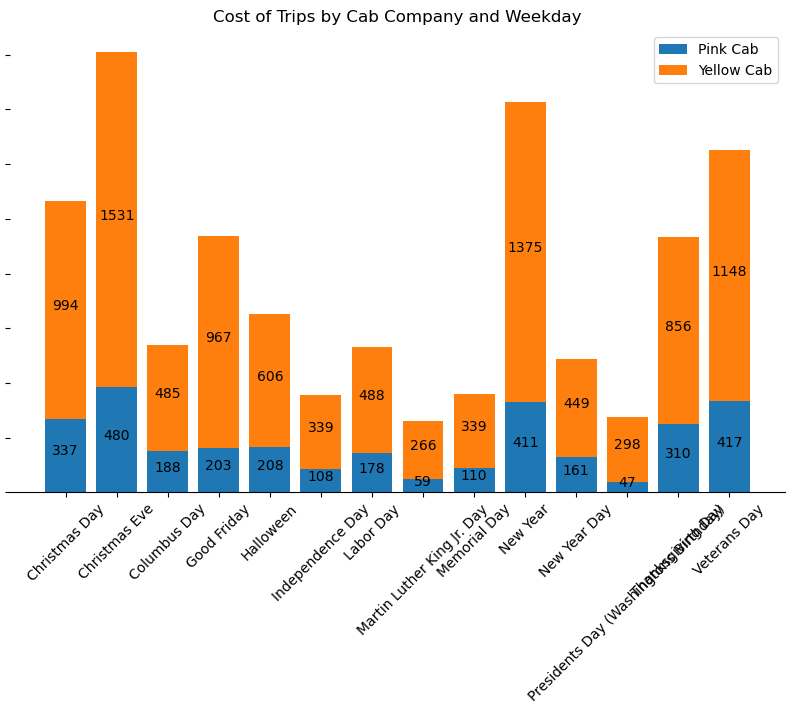

In [60]:
plt.figure(figsize=(10, 6))

# Filter data by cab company
pink_cab = user[user['Company'] == 'Pink Cab']
yellow_cab = user[user['Company'] == 'Yellow Cab']

# Reset index of dataframes
pink_cab = pink_cab.reset_index()
yellow_cab = yellow_cab.reset_index()

# Create stacked bar plot
plt.bar(pink_cab['holidays'], pink_cab['Users'], label='Pink Cab')
plt.bar(yellow_cab['holidays'], yellow_cab['Users'], bottom=pink_cab['Users'], label='Yellow Cab')

# Add values on top of bars
for i in range(len(pink_cab)):
    x = pink_cab['holidays'][i]
    y_pink = pink_cab['Users'].iloc[i]
    y_yellow = yellow_cab['Users'].iloc[i]
    plt.text(x, y_pink/2, round(y_pink,2), ha='center', fontsize=10)
    plt.text(x, y_pink+y_yellow/2, round(y_yellow,2), ha='center', fontsize=10)

# Remove y-axis label
plt.tick_params(axis='y', labelleft=False)
plt.xticks(rotation=45)
# Remove left, right, and top borders
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add title and legend
plt.title('Cost of Trips by Cab Company on holidays')
plt.legend()

plt.show()


## Hypothses 2: Average Earnings by Company Based on Weekdays

In [63]:
weeks = data.groupby(['Company','Customer_ID','weekday_name']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'mean'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
weeks1 = weeks.groupby(['Company', 'weekday_name']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'mean'
}).reset_index()

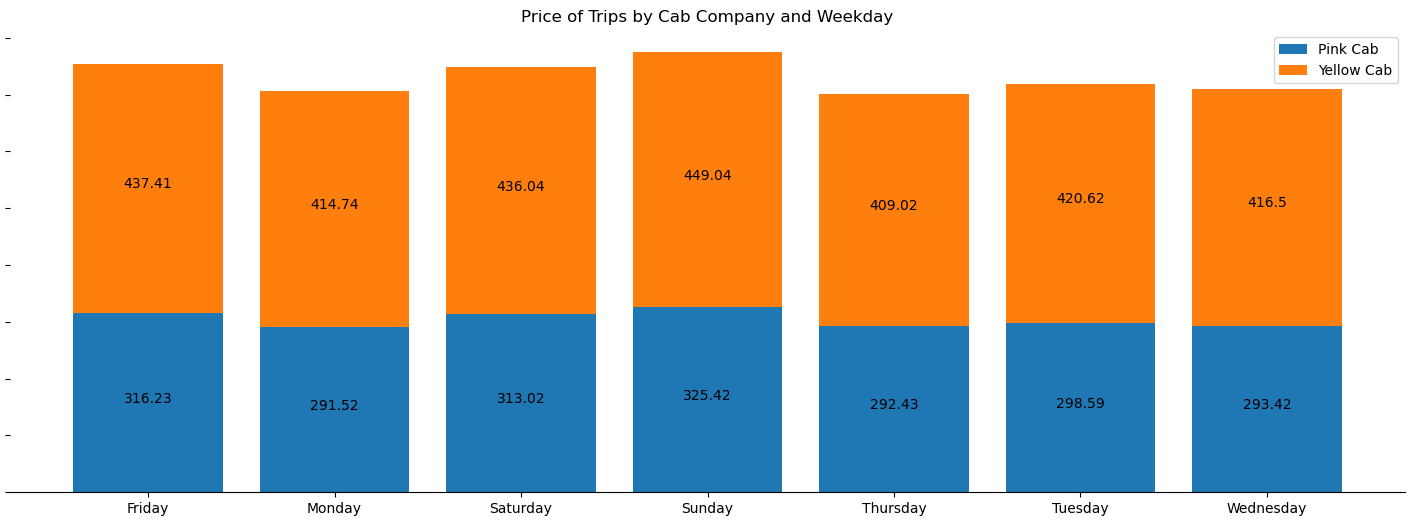

In [98]:
plt.figure(figsize=(18, 6))

# Filter data by cab company
pink_cab = weeks1[weeks1['Company'] == 'Pink Cab']
yellow_cab = weeks1[weeks1['Company'] == 'Yellow Cab']

# Reset index of dataframes
pink_cab = pink_cab.reset_index()
yellow_cab = yellow_cab.reset_index()

# Create stacked bar plot
plt.bar(pink_cab['weekday_name'], pink_cab['Price_Charged'], label='Pink Cab')
plt.bar(yellow_cab['weekday_name'], yellow_cab['Price_Charged'], bottom=pink_cab['Price_Charged'], label='Yellow Cab')

# Add values on top of bars
for i in range(len(pink_cab)):
    x = pink_cab['weekday_name'][i]
    y_pink = pink_cab['Price_Charged'].iloc[i]
    y_yellow = yellow_cab['Price_Charged'].iloc[i]
    plt.text(x, y_pink/2, round(y_pink,2), ha='center', fontsize=10)
    plt.text(x, y_pink+y_yellow/2, round(y_yellow,2), ha='center', fontsize=10)

# Remove y-axis label
plt.tick_params(axis='y', labelleft=False)

# Remove left, right, and top borders
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add title and legend
plt.title('Price of Trips by Cab Company and Weekday')
plt.legend()

plt.show()


In [134]:
profit = data.groupby(['Company','Customer_ID','weekday_name']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
profit1 = profit.groupby(['Company', 'weekday_name']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index()
profit1['Profit'] = ((profit1['Price_Charged'] - profit1['Cost_of_Trip'])/(profit1['Cost_of_Trip']))*100
profit1P = profit1.query("Company == 'Pink Cab'")
profit1Y = profit1.query("Company == 'Yellow Cab'")

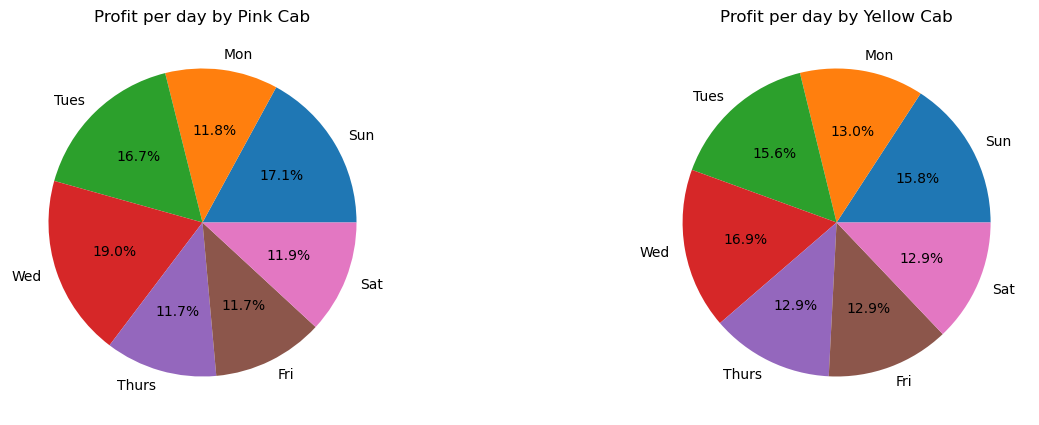

In [142]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Create first pie chart in first subplot
axs[0].pie(profit1P['Profit'], labels=['Sun','Mon','Tues','Wed','Thurs','Fri','Sat'], autopct='%1.1f%%')
axs[0].set_title('Profit per day by Pink Cab')

# Create second pie chart in second subplot
axs[1].pie(profit1Y['Profit'], labels=['Sun','Mon','Tues','Wed','Thurs','Fri','Sat'], autopct='%1.1f%%')
axs[1].set_title('Profit per day by Yellow Cab')

# Display plot
plt.show()


## Hypotheses 3: Average Profit by Company Based on Month

In [144]:
months = data.groupby(['Company','Customer_ID','month']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'mean'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
months1 = months.groupby(['Company', 'month']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'mean'
}).reset_index()

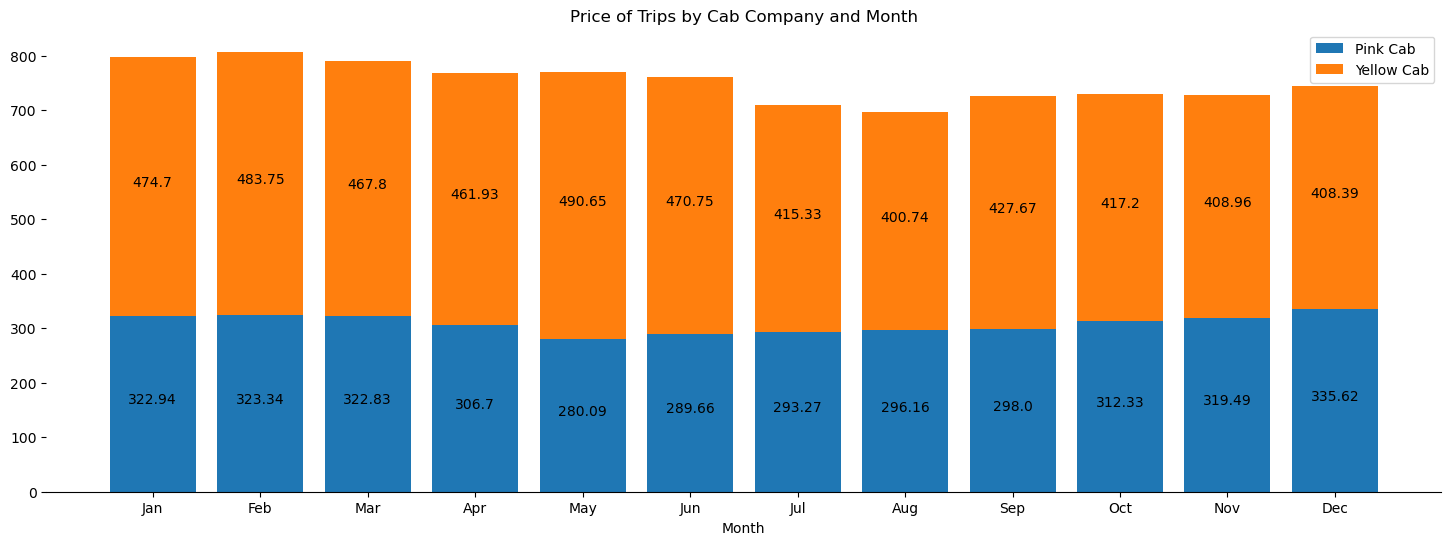

In [155]:
import numpy as np

# Define the month labels as a list of strings
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(18, 6))

# Filter data by cab company
pink_cab = months1[months1['Company'] == 'Pink Cab']
yellow_cab = months1[months1['Company'] == 'Yellow Cab']

# Reset index of dataframes
pink_cab = pink_cab.reset_index()
yellow_cab = yellow_cab.reset_index()

# Create stacked bar plot
plt.bar(pink_cab['month'], pink_cab['Price_Charged'], label='Pink Cab')
plt.bar(yellow_cab['month'], yellow_cab['Price_Charged'], bottom=pink_cab['Price_Charged'], label='Yellow Cab')

# Add values on top of bars
for i in range(len(pink_cab)):
    x = pink_cab['month'][i]
    y_pink = pink_cab['Price_Charged'].iloc[i]
    y_yellow = yellow_cab['Price_Charged'].iloc[i]
    plt.text(x, y_pink/2, round(y_pink,2), ha='center', fontsize=10)
    plt.text(x, y_pink+y_yellow/2, round(y_yellow,2), ha='center', fontsize=10)

# Remove y-axis label
plt.tick_params(axis='y')

# Remove left, right, and top borders
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add title and legend
plt.title('Price of Trips by Cab Company and Month')
plt.xlabel('Month')
plt.legend()
plt.xticks(np.arange(1, 13), month_labels)

plt.show()


In [147]:
profit = data.groupby(['Company','Customer_ID','month']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
profit1 = profit.groupby(['Company', 'month']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index()
profit1['Profit'] = ((profit1['Price_Charged'] - profit1['Cost_of_Trip'])/(profit1['Cost_of_Trip']))*100
profit1P = profit1.query("Company == 'Pink Cab'")
profit1Y = profit1.query("Company == 'Yellow Cab'")

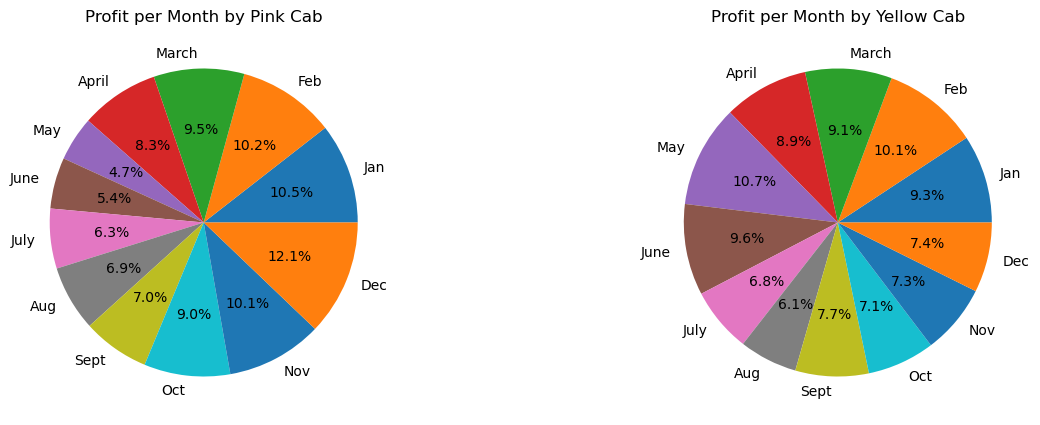

In [149]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Create first pie chart in first subplot
axs[0].pie(profit1P['Profit'], labels=['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 
                                              'Oct', 'Nov', 'Dec'], autopct='%1.1f%%')
axs[0].set_title('Profit per Month by Pink Cab')

# Create second pie chart in second subplot
axs[1].pie(profit1Y['Profit'], labels=['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 
                                              'Oct', 'Nov', 'Dec'], autopct='%1.1f%%')
axs[1].set_title('Profit per Month by Yellow Cab')

# Display plot
plt.show()


## Hypotheses 4:  Profit per KM and ride by each company

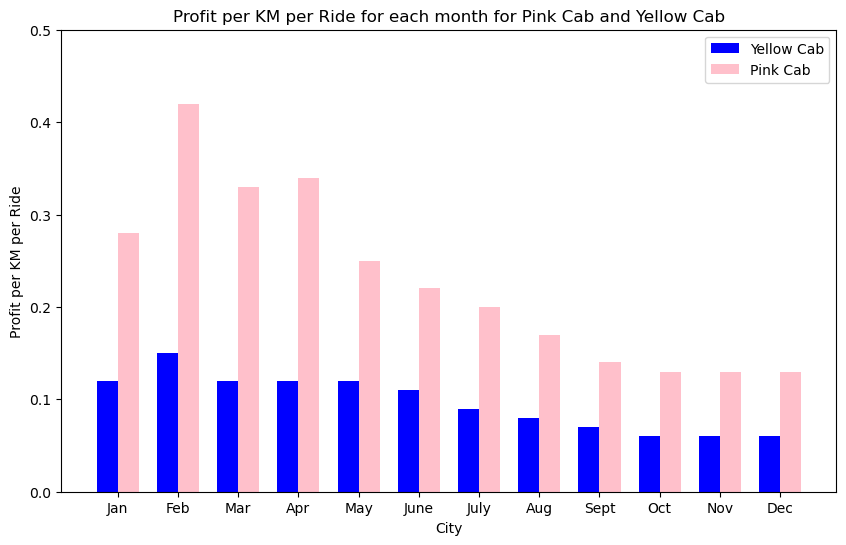

In [68]:
import matplotlib.pyplot as plt

mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May','June', 'July', 'Aug', 'Sept', 'Oct', 'Nov','Dec']

# Set figure size
plt.figure(figsize=(10, 6))

# Define data
x = np.arange(len(monthcab['month']))  # the x locations for the groups
width = 0.35  # the width of the bars

# Create a bar graph of the number of transactions per month for each company:
plt.bar(x - width/2, monthcab['Price_Charged_per_Ride'], width, color='blue', label='Yellow Cab')
plt.bar(x + width/2, month_cab['Price_Charged_per_Ride'], width, color='pink', label='Pink Cab')

# Set axis labels and title
plt.xlabel('City')
plt.ylabel('Profit per KM per Ride')
plt.title('Profit per KM per Ride for each month for Pink Cab and Yellow Cab')
plt.ylim(0.0,0.5)
plt.xticks(x, mon)

# Show legend and plot
plt.legend()
plt.show()

## Hypotheses 5: Profit per year by each company

In [162]:
years = data.groupby(['Company','Customer_ID','year']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'mean'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
years1 = years.groupby(['Company', 'year']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'mean'
}).reset_index()

In [168]:
profit = data.groupby(['Company','Customer_ID','year']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
profit1 = profit.groupby(['Company', 'year']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index()
profit1['Profit'] = ((profit1['Price_Charged'] - profit1['Cost_of_Trip'])/(profit1['Cost_of_Trip']))*100
profit1P = profit1.query("Company == 'Pink Cab'")
profit1Y = profit1.query("Company == 'Yellow Cab'")

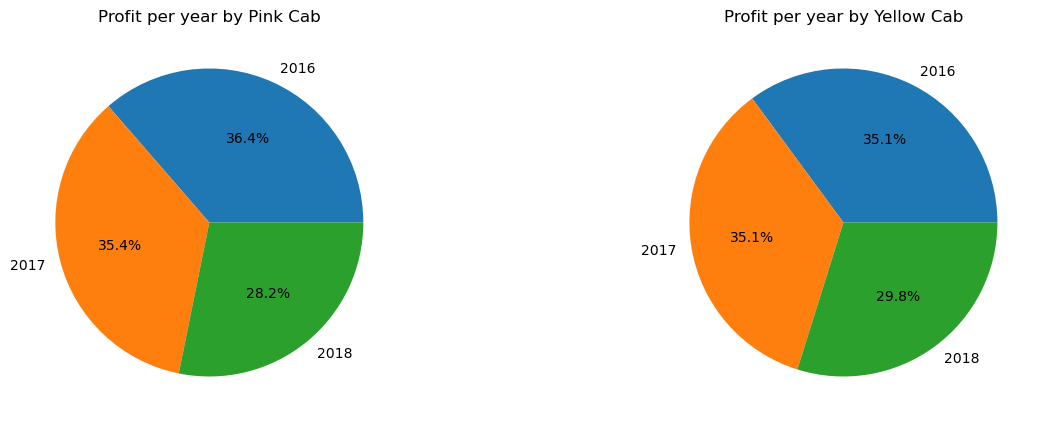

In [169]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Create first pie chart in first subplot
axs[0].pie(profit1P['Profit'], labels=['2016','2017','2018'], autopct='%1.1f%%')
axs[0].set_title('Profit per year by Pink Cab')

# Create second pie chart in second subplot
axs[1].pie(profit1Y['Profit'], labels=['2016','2017','2018'], autopct='%1.1f%%')
axs[1].set_title('Profit per year by Yellow Cab')

# Display plot
plt.show()

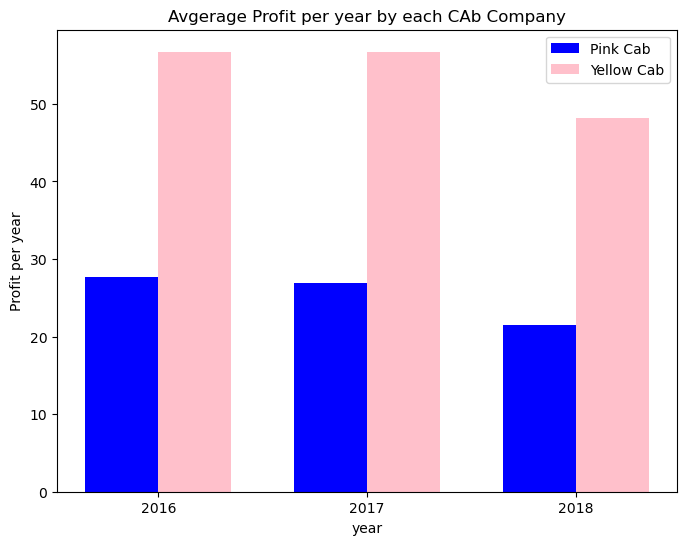

In [173]:
# Set figure size
plt.figure(figsize=(8, 6))

# Define data
x = np.arange(len(profit1P['year']))  # the x locations for the groups
width = 0.35  # the width of the bars

# Create a bar graph of the number of transactions per month for each company:
plt.bar(x - width/2, profit1P['Profit'], width, color='blue', label='Pink Cab')
plt.bar(x + width/2, profit1Y['Profit'], width, color='pink', label='Yellow Cab')

# Set axis labels and title
plt.xlabel('year')
plt.ylabel('Profit per year')
plt.title('Avgerage Profit per year by each CAb Company')

plt.xticks(x, ['2016','2017','2018'])

# Show legend and plot
plt.legend()
plt.show()

## Hypotheses 6 : Total profit per city by each company

In [191]:
profit = data.groupby(['Company','Customer_ID','City']).agg({
    'Transcation_ID':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
profit1 = profit.groupby(['Company', 'City']).agg({
    'num_of_trans':'count',
    'Price_Charged': 'sum',
    'Cost_of_Trip': 'sum'
}).reset_index()
profit1['Profit'] = ((profit1['Price_Charged'] - profit1['Cost_of_Trip'])/(profit1['Cost_of_Trip']))*100
profit1['Profit_per_km'] = round((profit1['Profit'] / profit1['num_of_trans'])*100,2)
profit1P = profit1.query("Company == 'Pink Cab'")
profit1Y = profit1.query("Company == 'Yellow Cab'")

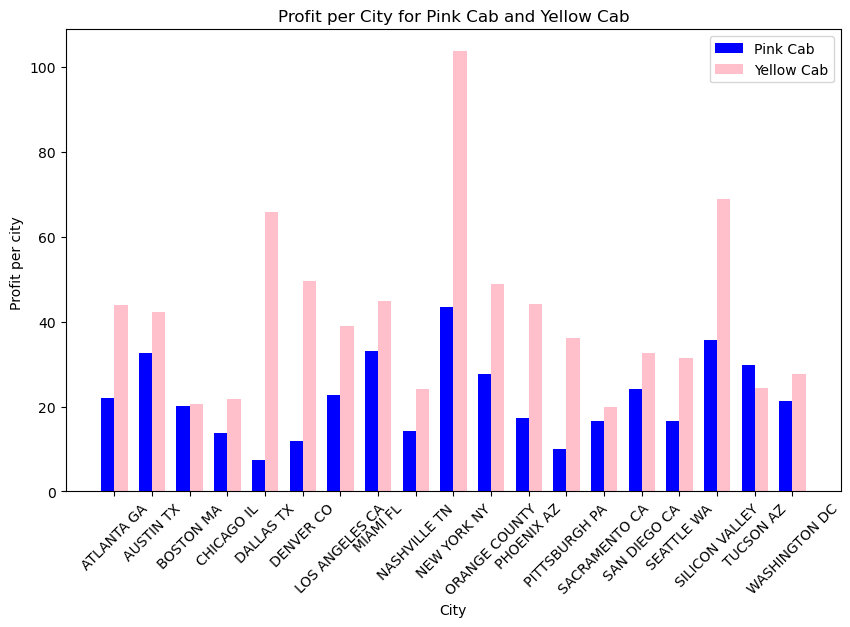

In [192]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Define data
x = np.arange(len(profit1Y['City']))  # the x locations for the groups
width = 0.35  # the width of the bars

# Create a bar graph of the number of transactions per month for each company:
plt.bar(x - width/2, profit1P['Profit'], width, color='blue', label='Pink Cab')
plt.bar(x + width/2, profit1Y['Profit'], width, color='pink', label='Yellow Cab')

# Set axis labels and title
plt.xlabel('City')
plt.ylabel('Profit per city ')
plt.title('Profit per City for Pink Cab and Yellow Cab')
plt.xticks(x, costcab['City'])
# plt.ylim(0.0, 3.0)
plt.xticks(rotation=45)
# Show legend and plot
plt.legend()
plt.show()

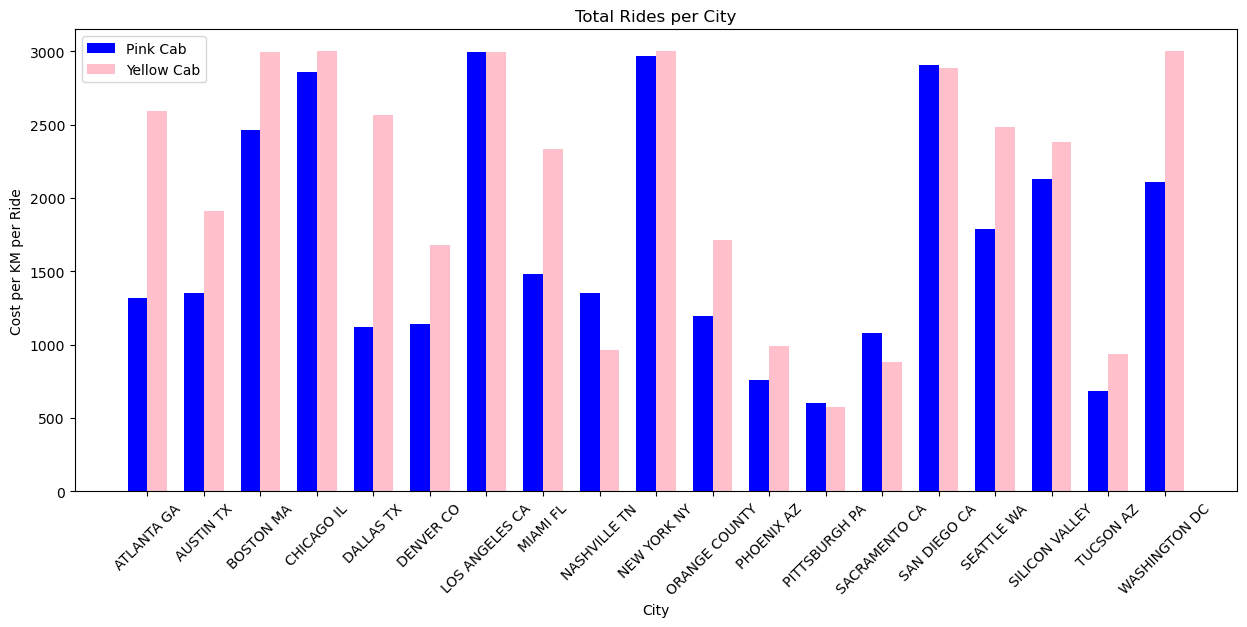

In [197]:
# Set figure size
plt.figure(figsize=(15, 6))

# Define data
x = np.arange(len(profit1P['City']))  # the x locations for the groups
width = 0.35  # the width of the bars

# Create a bar graph of the number of transactions per month for each company:
plt.bar(x - width/2, profit1P['num_of_trans'], width, color='blue', label='Pink Cab')
plt.bar(x + width/2, profit1Y['num_of_trans'], width, color='pink', label='Yellow Cab')

# Set axis labels and title
plt.xlabel('City')
plt.ylabel('Cost per KM per Ride')
plt.title('Total Rides per City')
plt.xticks(x, profit1P['City'])
# plt.ylim(1000.0, 2000.2)
plt.xticks(rotation=45)

# Show legend and plot
plt.legend()
plt.show()

## Hypotheses 7: Profit per km per ride by city wise

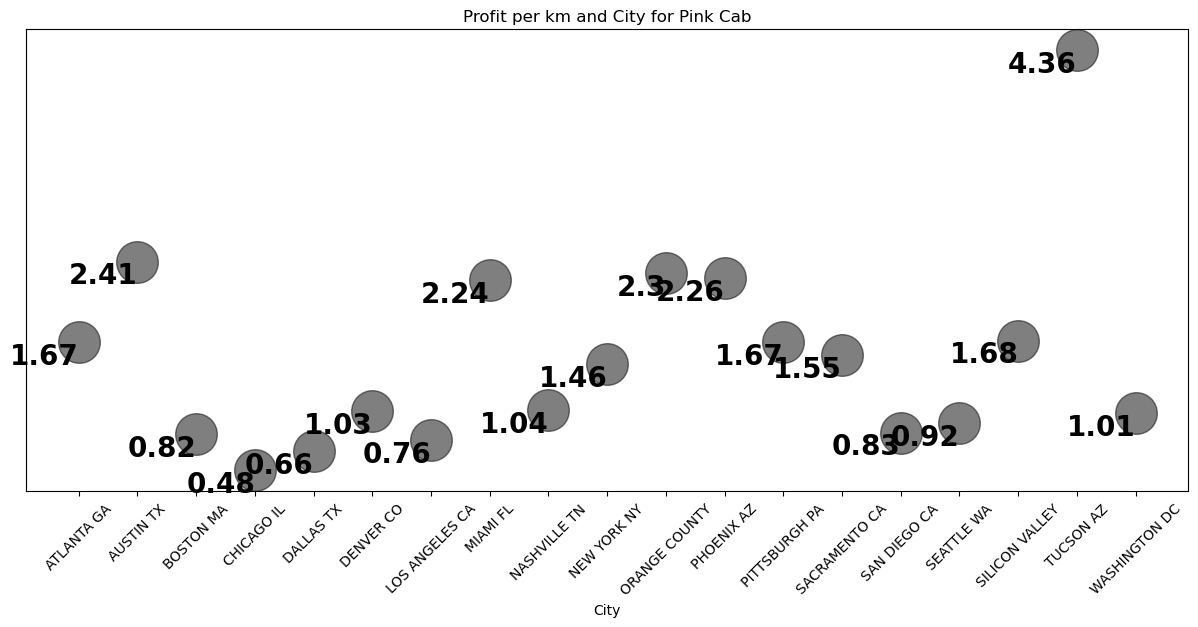

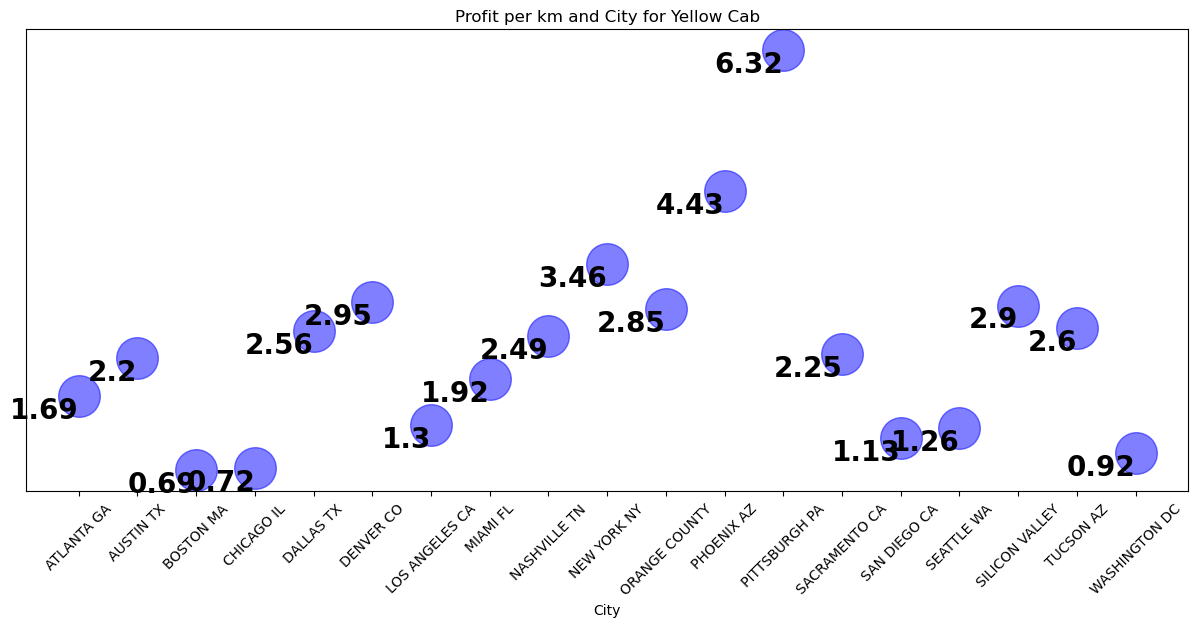

In [186]:
plt.figure(figsize=(15, 6))

# Define data
x = profit1P['City']
y = profit1P['Profit_per_km']

# Create scatter plot with circle markers
plt.scatter(x, y, s=900, alpha=0.5, c='black')

# Set axis labels and title
plt.xlabel('City')
plt.ylabel('Profit per km')
plt.title('Profit per km and City for Pink Cab')

# Remove y-axis
plt.gca().get_yaxis().set_visible(False)

# Add text to circles
for i, x, y in zip(range(len(x)), x, y):
    plt.text(x, y, y, ha="right", va="top", fontweight='bold', fontsize=20)
plt.xticks(rotation=45)

# Show plot
plt.show()

plt.figure(figsize=(15, 6))

# Define data
x = profit1Y['City']
y = profit1Y['Profit_per_km']

# Create scatter plot with circle markers
plt.scatter(x, y, s=900, alpha=0.5, c='blue')

# Set axis labels and title
plt.xlabel('City')
plt.ylabel('Profit per km')
plt.title('Profit per km and City for Yellow Cab')

# Remove y-axis
plt.gca().get_yaxis().set_visible(False)
plt.xticks(rotation=45)

# Add text to circles
for i, x, y in zip(range(len(x)), x, y):
    plt.text(x, y, y, ha="right", va="top", fontweight='bold', fontsize=20)

# Show plot
plt.show()

## Hypothses 8: Total number of rides per year

In [198]:
group = data.groupby(['Company', 'Customer_ID', 'year']).agg({
    'Transcation_ID':'count',
}).reset_index().rename(columns={'Transcation_ID': 'num_of_trans'})
group = pd.DataFrame(group)

group1 = group.groupby(['Company', 'year', 'num_of_trans']).agg({
    'num_of_trans':'count',
}).rename(columns={'num_of_trans': 'total'}).reset_index()

# print(group1)

cab_20161 = group1.query("Company == 'Pink Cab' and year == 2016")
cab_20172 = group1.query("Company == 'Pink Cab' and year == 2017")
cab_20183 = group1.query("Company == 'Pink Cab' and year == 2018")
cab20161 = group1.query("Company == 'Yellow Cab' and year == 2016")
cab20172 = group1.query("Company == 'Yellow Cab' and year == 2017")
cab20183 = group1.query("Company == 'Yellow Cab' and year == 2018")
cab2018 = group1.query("Company == 'Pink Cab' and year == 2018")


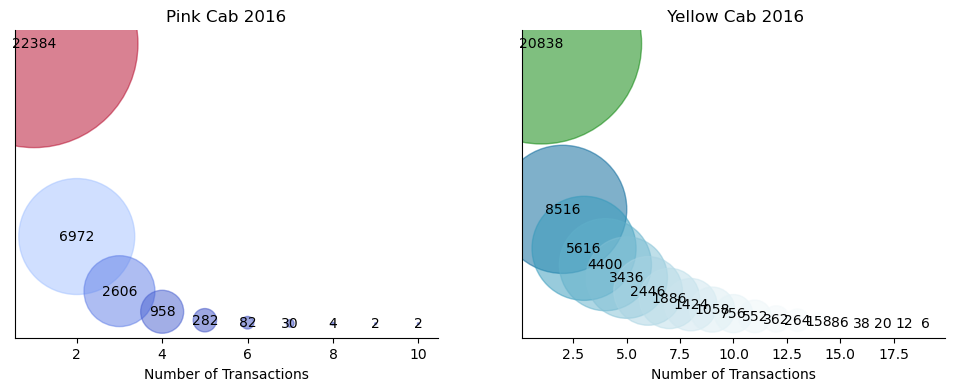

In [199]:
import matplotlib.pyplot as plt
import numpy as np

# Define data for 2016
x1 = cab_20161['num_of_trans']
y1 = cab_20161['total']
size1 = cab_20161['total'] * 2
colors1 = size1/np.max(size1) # set color based on size

# Define data for 2016
x2 = cab20161['num_of_trans']
y2 = cab20161['total']
size2 = cab20161['total'] * 2
colors2 = size2/np.max(size2) # set color based on size

# Create two separate plots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot for 2016 data
axs[0].scatter(x1, y1, s=size1, alpha=0.5, c=colors1, cmap='coolwarm')
axs[0].set_xlabel('Number of Transactions')
axs[0].set_ylabel('Total Transactions')
axs[0].set_title('Pink Cab 2016')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(False)
axs[0].get_yaxis().set_visible(False)

# Add text to circles in 2016 plot
for i, x, y, s in zip(range(len(x1)), x1, y1, size1):
    axs[0].text(x, y, s, ha="center", va="center")

# Plot for 2017 data
axs[1].scatter(x2, y2, s=size2, alpha=0.5, c=colors2, cmap='ocean_r')
axs[1].set_xlabel('Number of Transactions')
axs[1].set_ylabel('Total Transactions')
axs[1].set_title(' Yellow Cab 2016')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].xaxis.grid(False)
axs[1].yaxis.grid(False)
axs[1].get_yaxis().set_visible(False)

# Add text to circles in 2017 plot
for i, x, y, s in zip(range(len(x2)), x2, y2, size2):
    axs[1].text(x, y, s, ha="center", va="center")

# Show plot
plt.show()


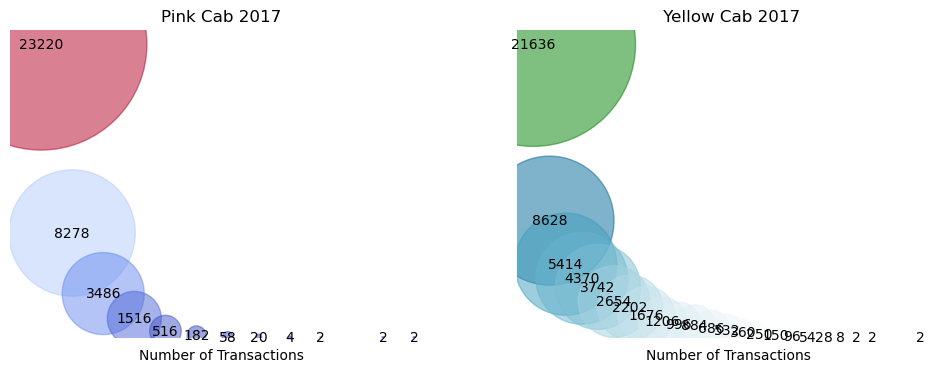

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Define data for 2016
x1 = cab_20172['num_of_trans']
y1 = cab_20172['total']
size1 = cab_20172['total'] * 2
colors1 = size1/np.max(size1) # set color based on size

# Define data for 2016
x2 = cab20172['num_of_trans']
y2 = cab20172['total']
size2 = cab20172['total'] * 2
colors2 = size2/np.max(size2) # set color based on size

# Create two separate plots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot for 2016 data
axs[0].scatter(x1, y1, s=size1, alpha=0.5, c=colors1, cmap='coolwarm')
axs[0].set_xlabel('Number of Transactions')
axs[0].set_ylabel('Total Transactions')
axs[0].set_title('Pink Cab 2017')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(False)
axs[0].get_yaxis().set_visible(False)

# Add text to circles in 2016 plot
for i, x, y, s in zip(range(len(x1)), x1, y1, size1):
    axs[0].text(x, y, s, ha="center", va="center")

# Plot for 2017 data
axs[1].scatter(x2, y2, s=size2, alpha=0.5, c=colors2, cmap='ocean_r')
axs[1].set_xlabel('Number of Transactions')
axs[1].set_ylabel('Total Transactions')
axs[1].set_title(' Yellow Cab 2017')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].xaxis.grid(False)
axs[1].yaxis.grid(False)
axs[1].get_yaxis().set_visible(False)

# Add text to circles in 2017 plot
for i, x, y, s in zip(range(len(x2)), x2, y2, size2):
    axs[1].text(x, y, s, ha="center", va="center")
    
plt.setp(axs, xlim=(0, None), ylim=(0, None), xticks=[], yticks=[], frame_on=False)

# Show plot
plt.show()

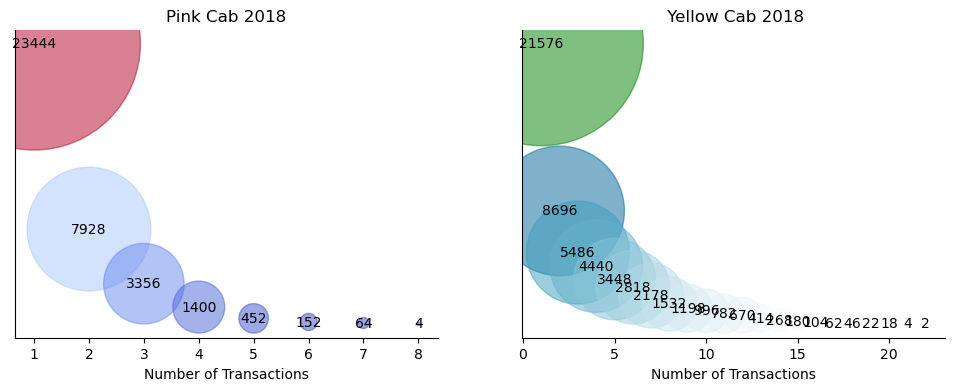

In [201]:
import matplotlib.pyplot as plt
import numpy as np

# Define data for 2016
x1 = cab_20183['num_of_trans']
y1 = cab_20183['total']
size1 = cab_20183['total'] * 2
colors1 = size1/np.max(size1) # set color based on size

# Define data for 2016
x2 = cab20183['num_of_trans']
y2 = cab20183['total']
size2 = cab20183['total'] * 2
colors2 = size2/np.max(size2) # set color based on size

# Create two separate plots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot for 2016 data
axs[0].scatter(x1, y1, s=size1, alpha=0.5, c=colors1, cmap='coolwarm')
axs[0].set_xlabel('Number of Transactions')
axs[0].set_ylabel('Total Transactions')
axs[0].set_title('Pink Cab 2018')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(False)
axs[0].get_yaxis().set_visible(False)

# Add text to circles in 2016 plot
for i, x, y, s in zip(range(len(x1)), x1, y1, size1):
    axs[0].text(x, y, s, ha="center", va="center")

# Plot for 2017 data
axs[1].scatter(x2, y2, s=size2, alpha=0.5, c=colors2, cmap='ocean_r')
axs[1].set_xlabel('Number of Transactions')
axs[1].set_ylabel('Total Transactions')
axs[1].set_title(' Yellow Cab 2018')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].xaxis.grid(False)
axs[1].yaxis.grid(False)
axs[1].get_yaxis().set_visible(False)

# Add text to circles in 2017 plot
for i, x, y, s in zip(range(len(x2)), x2, y2, size2):
    axs[1].text(x, y, s, ha="center", va="center")

# Show plot
plt.show()


## Growth of company by customer retention

In [202]:
import matplotlib.pyplot as plt

grouped_data = data.groupby(['Company', 'Customer_ID','year']).agg({
    'Transcation_ID': 'count',
#     'Company': 'count',
})
l1 = {}
l2 = {}
cab_20161 = grouped_data.query("Transcation_ID > 2 and Transcation_ID <= 5 and Company == 'Pink Cab' and year == 2016")
cab_20162 = grouped_data.query("Transcation_ID > 5 and Transcation_ID <= 10 and Company == 'Pink Cab' and year == 2016")
cab_20163 = grouped_data.query("Transcation_ID > 10 and Company == 'Pink Cab' and year == 2016")
cab_20171 = grouped_data.query("Transcation_ID > 2 and Transcation_ID <= 5 and Company == 'Pink Cab' and year == 2017")
cab_20172 = grouped_data.query("Transcation_ID > 5 and Transcation_ID <= 10 and Company == 'Pink Cab' and year == 2017")
cab_20173 = grouped_data.query("Transcation_ID > 10 and Company == 'Pink Cab' and year == 2017")
cab_20181 = grouped_data.query("Transcation_ID > 2 and Transcation_ID <= 5 and Company == 'Pink Cab' and year == 2018")
cab_20182 = grouped_data.query("Transcation_ID > 5 and Transcation_ID <= 10 and Company == 'Pink Cab' and year == 2018")
cab_20183 = grouped_data.query("Transcation_ID > 10 and Company == 'Pink Cab' and year == 2018")

cab20161 = grouped_data.query("Transcation_ID > 2 and Transcation_ID <= 5 and Company == 'Yellow Cab' and year == 2016")
cab20162 = grouped_data.query("Transcation_ID > 5 and Transcation_ID <= 10 and Company == 'Yellow Cab' and year == 2016")
cab20163 = grouped_data.query("Transcation_ID > 10 and Company == 'Yellow Cab' and year == 2016")
cab20171 = grouped_data.query("Transcation_ID > 2 and Transcation_ID <= 5 and Company == 'Yellow Cab' and year == 2017")
cab20172 = grouped_data.query("Transcation_ID > 5 and Transcation_ID <= 10 and Company == 'Yellow Cab' and year == 2017")
cab20173 = grouped_data.query("Transcation_ID > 10 and Company == 'Yellow Cab' and year == 2017")
cab20181 = grouped_data.query("Transcation_ID > 2 and Transcation_ID <= 5 and Company == 'Yellow Cab' and year == 2018")
cab20182 = grouped_data.query("Transcation_ID > 5 and Transcation_ID <= 10 and Company == 'Yellow Cab' and year == 2018")
cab20183 = grouped_data.query("Transcation_ID > 10 and Company == 'Yellow Cab' and year == 2018")

l1['2016'] = [cab_20161['Transcation_ID'].sum(), cab_20162['Transcation_ID'].sum(), cab_20163['Transcation_ID'].sum()]
l1['2017'] = [cab_20171['Transcation_ID'].sum(), cab_20172['Transcation_ID'].sum(), cab_20173['Transcation_ID'].sum()]
l1['2018'] = [cab_20181['Transcation_ID'].sum(), cab_20182['Transcation_ID'].sum(), cab_20183['Transcation_ID'].sum()]

l2['2016'] = [cab20161['Transcation_ID'].sum(), cab20162['Transcation_ID'].sum(), cab20163['Transcation_ID'].sum()]
l2['2017'] = [cab20171['Transcation_ID'].sum(), cab20172['Transcation_ID'].sum(), cab20173['Transcation_ID'].sum()]
l2['2018'] = [cab20181['Transcation_ID'].sum(), cab20182['Transcation_ID'].sum(), cab20183['Transcation_ID'].sum()]

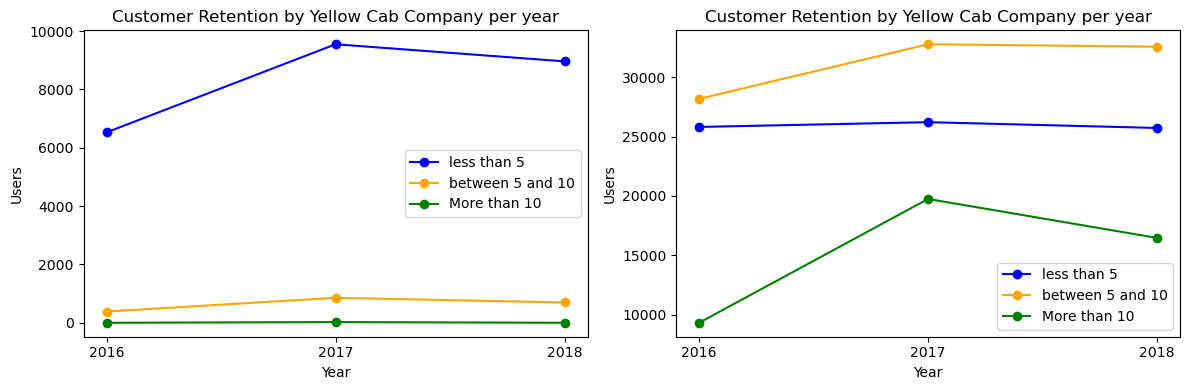

In [205]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

# Plot the first graph in the first subplot
values = [l1[key][0] for key in l1]
values1 = [l1[key][1] for key in l1]
values2 = [l1[key][2] for key in l1]
axs[0].plot(values, marker='o', color='blue', label='less than 5')
axs[0].plot(values1, marker='o',color='orange' , label='between 5 and 10')
axs[0].plot(values2, marker='o', color='green' , label='More than 10')
axs[0].legend()
axs[0].set_title('Customer Retention by Yellow Cab Company per year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Users')
axs[0].set_xticks([0, 1, 2])
axs[0].set_xticklabels(['2016', '2017', '2018'])

# Plot the second graph in the second subplot
val = [l2[key][0] for key in l2]
val1 = [l2[key][1] for key in l2]
val2 = [l2[key][2] for key in l2]
axs[1].plot(val, marker='o', label='less than 5', color='blue')
axs[1].plot(val1, marker='o', label='between 5 and 10', color='orange')
axs[1].plot(val2, marker='o', label='More than 10', color='green')
axs[1].legend()
axs[1].set_title('Customer Retention by Yellow Cab Company per year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Users')
axs[1].set_xticks([0, 1, 2])
axs[1].set_xticklabels(['2016', '2017', '2018'])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [206]:
data = data.drop(['Customer_ID','Transcation_ID','Income(USD)','weekday_name','Payment_Mode'], axis=1)

In [207]:
data

,Price_Charged,Company,Distance,Cost_of_Trip,Age,day,month,year,City,Users,holidays,Population
0,370.95,Pink Cab,30.45,313.6350,28,8,1,2016,ATLANTA GA,"24,701",FALSE,"814,885"
1,609.50,Yellow Cab,18.90,267.6240,28,8,1,2016,ATLANTA GA,"24,701",FALSE,"814,885"
2,360.79,Pink Cab,25.52,298.5840,53,8,1,2016,BOSTON MA,"80,021",FALSE,"248,968"
3,498.02,Pink Cab,34.22,407.2180,27,8,1,2016,BOSTON MA,"80,021",FALSE,"248,968"
4,703.49,Yellow Cab,36.36,436.3200,32,8,1,2016,BOSTON MA,"80,021",FALSE,"248,968"
...,...,...,...,...,...,...,...,...,...,...,...,...
359387,178.07,Yellow Cab,9.36,132.5376,28,21,1,2016,WASHINGTON DC,"127,001",FALSE,"418,859"
359388,93.69,Yellow Cab,5.80,76.5600,27,21,1,2016,WASHINGTON DC,"127,001",FALSE,"418,859"
359389,703.56,Yellow Cab,39.20,489.2160,19,21,1,2016,WASHINGTON DC,"127,001",FALSE,"418,859"
359390,699.34,Yellow Cab,40.17,506.1420,39,21,1,2016,WASHINGTON DC,"127,001",FALSE,"418,859"


In [208]:
# Initialize one-hot encoder
encoder = OneHotEncoder()

# Fit encoder to data and transform data
one_hot = encoder.fit_transform(data[['City', 'holidays']])

# Convert sparse matrix to dense matrix and create new DataFrame with one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot.toarray(), columns=encoder.get_feature_names_out(['City', 'holidays',]))


In [209]:
# Concatenate one-hot encoded DataFrame with original DataFrame
data = pd.concat([data, one_hot_df], axis=1)

# Drop original categorical columns
data = data.drop(columns=['City', 'holidays','Population'])


In [210]:
# Replace commas with empty string in 'Users' column
data['Users'] = data['Users'].str.replace(',', '')

# Convert 'Users' column to float
data['Users'] = data['Users'].astype(float)

In [211]:
#Create an instance of the LabelEncoder class
le = LabelEncoder()

# Fit the encoder to the classification column and transform it
label = le.fit_transform(data['Company'])
label = pd.DataFrame(label)

data = pd.concat([data, label], axis=1)

# Print the encoded column
data = data.drop(columns=['Company'])
data = data.rename(columns={0: 'Company'})

In [ ]:
# Split the data into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)